# Easy vs Hard Jets Analysis

This notebook analyzes the difference between jets that were correctly classified (easy) and incorrectly classified (hard) by the LLM.

**Analysis Steps:**
1. Load LLM analysis results with jet indices
2. Classify jets as easy (correct) vs hard (incorrect)
3. Compute kinematic and substructure properties
4. Identify distinguishing characteristics
5. Visualize differences and save results

In [1]:
# Imports
import json
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

# Set plot style
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

## Configuration

In [2]:
# Configuration
RESULTS_FILE = project_root / "results" / "llm_analysis_20251013_113115.json"
TEMPLATE = "with_optimal_cut"
REASONING_EFFORT = "low"
DATA_PATH = project_root / "data" / "qg_jets.npz"
OUTPUT_DIR = project_root / "results" / "easy_hard_analysis"

# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Configuration:")
print(f"  Results file: {RESULTS_FILE.name}")
print(f"  Template: {TEMPLATE}")
print(f"  Reasoning: {REASONING_EFFORT}")
print(f"  Data path: {DATA_PATH}")
print(f"  Output dir: {OUTPUT_DIR}")

Configuration:
  Results file: llm_analysis_20251013_113115.json
  Template: with_optimal_cut
  Reasoning: low
  Data path: /lustre/hpc/pheno/inar/vibe-jet-tagging/data/qg_jets.npz
  Output dir: /lustre/hpc/pheno/inar/vibe-jet-tagging/results/easy_hard_analysis


## Load Analysis Results

In [19]:
# Load LLM analysis results
with open(RESULTS_FILE) as f:
    analysis_data = json.load(f)

print(f"✓ Loaded results from {RESULTS_FILE.name}")
print(f"  Number of configurations: {len(analysis_data['results'])}")
print(f"\nMetadata:")
for key, value in analysis_data['metadata'].items():
    print(f"  {key}: {value}")

✓ Loaded results from llm_analysis_20251013_113115.json
  Number of configurations: 1

Metadata:
  num_jets: 1000
  templates: ['with_optimal_cut']
  reasoning_efforts: ['low']
  model_name: openai/gpt-oss-120b
  base_url: http://localhost:8000/v1
  data_path: /lustre/hpc/pheno/inar/vibe-jet-tagging/data/qg_jets.npz
  templates_dir: /lustre/hpc/pheno/inar/vibe-jet-tagging/templates
  random_sample: False
  seed: 42
  total_elapsed_time: 104.1894063949585
  timestamp: 2025-10-13 11:33:38


## Extract Configuration Results

In [20]:
# Find the specific configuration
result = None
for r in analysis_data["results"]:
    if r["template"] == TEMPLATE and r["reasoning_effort"] == REASONING_EFFORT:
        result = r
        break

if result is None:
    print(f"\n❌ Could not find results for template={TEMPLATE}, reasoning={REASONING_EFFORT}")
    print(f"Available configurations:")
    for r in analysis_data["results"]:
        print(f"  - {r['template']}, {r['reasoning_effort']}")
else:
    print(f"✓ Found configuration:")
    print(f"  Template: {result['template']}")
    print(f"  Reasoning: {result['reasoning_effort']}")
    print(f"  Accuracy: {result['accuracy']:.4f}")
    print(f"  AUC: {result['auc']:.4f}")
    print(f"  Num jets: {result['num_jets']}")
    print(f"  Avg time per jet: {result['avg_time_per_jet']:.4f}s")

✓ Found configuration:
  Template: with_optimal_cut
  Reasoning: low
  Accuracy: 0.7520
  AUC: 0.7535
  Num jets: 1000
  Avg time per jet: 0.1033s


## Classify Jets as Easy vs Hard

In [5]:
# Classify jets as easy (correct) or hard (incorrect)
predictions = np.array(result["predictions"])
true_labels = np.array(result["true_labels"])
jet_indices = np.array(result["jet_indices"])

# Determine correct predictions
correct = predictions == true_labels

# Split into easy and hard
easy_indices = jet_indices[correct]
hard_indices = jet_indices[~correct]

print(f"Jet Classification:")
print(f"  Easy jets (correct): {len(easy_indices)} ({len(easy_indices)/len(jet_indices)*100:.1f}%)")
print(f"  Hard jets (incorrect): {len(hard_indices)} ({len(hard_indices)/len(jet_indices)*100:.1f}%)")

Jet Classification:
  Easy jets (correct): 752 (75.2%)
  Hard jets (incorrect): 248 (24.8%)


## Load Jet Data

In [6]:
# Load jet data
print(f"Loading jet data from {DATA_PATH}...")
data_npz = np.load(DATA_PATH)
X_all = data_npz["X"]
y_all = data_npz["y"]

print(f"✓ Loaded jet data")
print(f"  Total jets: {len(X_all)}")
print(f"  Jet shape: {X_all.shape}")
print(f"  Features: (px, py, pz, E)")

# Extract easy and hard jets
X_easy = X_all[easy_indices]
y_easy = y_all[easy_indices]
X_hard = X_all[hard_indices]
y_hard = y_all[hard_indices]

print(f"\nSplit by difficulty:")
print(f"  Easy jets: {len(X_easy)} (quark: {(y_easy==1).sum()}, gluon: {(y_easy==0).sum()})")
print(f"  Hard jets: {len(X_hard)} (quark: {(y_hard==1).sum()}, gluon: {(y_hard==0).sum()})")

Loading jet data from /lustre/hpc/pheno/inar/vibe-jet-tagging/data/qg_jets.npz...
✓ Loaded jet data
  Total jets: 100000
  Jet shape: (100000, 139, 4)
  Features: (px, py, pz, E)

Split by difficulty:
  Easy jets: 752 (quark: 351, gluon: 401)
  Hard jets: 248 (quark: 160, gluon: 88)
✓ Loaded jet data
  Total jets: 100000
  Jet shape: (100000, 139, 4)
  Features: (px, py, pz, E)

Split by difficulty:
  Easy jets: 752 (quark: 351, gluon: 401)
  Hard jets: 248 (quark: 160, gluon: 88)


## Baseline Comparison: Multiplicity-Based Classifier

Before analyzing what makes jets "easy" vs "hard" for the LLM, let's see how a simple multiplicity-based classifier performs on the same 1000 jets. This will give us context for the LLM's performance.

In [16]:
# Extract the same 1000 jets that were analyzed by the LLM
X_analyzed = X_all[jet_indices]
y_analyzed = y_all[jet_indices]

print(f"Analyzing the same {len(X_analyzed)} jets that the LLM classified:")
print(f"  Quark jets: {(y_analyzed==1).sum()}") 
print(f"  Gluon jets: {(y_analyzed==0).sum()}")

# Compute multiplicity for these jets
mult_analyzed = np.sum(X_analyzed[:, :, 0] > 0, axis=1)

print(f"\nMultiplicity statistics:")
print(f"  Overall: {mult_analyzed.mean():.1f} ± {mult_analyzed.std():.1f}")
print(f"  Quark jets: {mult_analyzed[y_analyzed==1].mean():.1f} ± {mult_analyzed[y_analyzed==1].std():.1f}")
print(f"  Gluon jets: {mult_analyzed[y_analyzed==0].mean():.1f} ± {mult_analyzed[y_analyzed==0].std():.1f}")

Analyzing the same 1000 jets that the LLM classified:
  Quark jets: 511
  Gluon jets: 489

Multiplicity statistics:
  Overall: 43.3 ± 17.6
  Quark jets: 33.7 ± 13.2
  Gluon jets: 53.4 ± 15.9


In [17]:
# Apply the multiplicity-based cut classifier from the baseline notebook
# We'll use the full dataset to find the optimal threshold, then apply to our 1000 jets

# First, load all data and find optimal threshold on a training set
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Use 80% of full dataset as training to find optimal threshold
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

mult_train_full = np.sum(X_train_full[:, :, 0] > 0, axis=1)

# Find optimal threshold by maximizing accuracy on training set
thresholds = np.arange(mult_train_full.min(), mult_train_full.max(), 1)
best_acc = 0
best_threshold = 0

for thresh in thresholds:
    # Predict: if mult > threshold => gluon (0), else quark (1)
    y_pred_train = (mult_train_full > thresh).astype(int)
    # Flip: predict 0 for high mult (gluon), 1 for low mult (quark)
    y_pred_train = 1 - y_pred_train
    acc_train = accuracy_score(y_train_full, y_pred_train)
    
    if acc_train > best_acc:
        best_acc = acc_train
        best_threshold = thresh

print(f"Optimal multiplicity threshold (from training set): {best_threshold}")
print(f"  Training accuracy at threshold: {best_acc:.4f}")
print(f"  Rule: if mult > {best_threshold} => gluon (0), else => quark (1)")

Optimal multiplicity threshold (from training set): 38
  Training accuracy at threshold: 0.7678
  Rule: if mult > 38 => gluon (0), else => quark (1)


In [21]:
# Now apply this threshold to the same 1000 jets that the LLM analyzed
y_pred_mult = (mult_analyzed > best_threshold).astype(int)
y_pred_mult = 1 - y_pred_mult  # Flip: 0=gluon (high mult), 1=quark (low mult)

# For ROC curve, use continuous multiplicity score
# Lower mult = more likely quark = higher score for class 1
y_prob_mult = 1.0 / (1.0 + np.exp((mult_analyzed - best_threshold) / 5.0))  # Sigmoid-like

# Evaluate multiplicity-based classifier
acc_mult = accuracy_score(y_analyzed, y_pred_mult)
auc_mult = roc_auc_score(y_analyzed, y_prob_mult)

print(f"\n{'='*70}")
print(f"MULTIPLICITY-BASED CLASSIFIER (on same 1000 jets as LLM)")
print(f"{'='*70}")
print(f"Cut threshold:  {best_threshold}")
print(f"Accuracy:       {acc_mult:.4f}")
print(f"AUC:            {auc_mult:.4f}")
print(f"{'='*70}")

# Show confusion matrix
cm_mult = confusion_matrix(y_analyzed, y_pred_mult)
print(f"\nConfusion matrix at threshold={best_threshold}:")
print(f"                Predicted")
print(f"              Gluon  Quark")
print(f"Actual Gluon  {cm_mult[0,0]:5d}  {cm_mult[0,1]:5d}")
print(f"       Quark  {cm_mult[1,0]:5d}  {cm_mult[1,1]:5d}")

# Compare with LLM performance
print(f"\n{'='*70}")
print(f"COMPARISON: LLM vs Multiplicity-Based Classifier")
print(f"{'='*70}")
print(f"{'Method':<30} {'Accuracy':<12} {'AUC':<12}")
print(f"{'-'*70}")
print(f"{'LLM (GPT-OSS-120B)':<30} {result['accuracy']:.4f}       {result['auc']:.4f}")
print(f"{'Multiplicity Cut':<30} {acc_mult:.4f}       {auc_mult:.4f}")
print(f"{'-'*70}")
print(f"{'Difference (LLM - Cut)':<30} {result['accuracy']-acc_mult:+.4f}       {result['auc']-auc_mult:+.4f}")
print(f"{'='*70}")

if result['accuracy'] > acc_mult:
    improvement_acc = ((result['accuracy'] - acc_mult) / acc_mult) * 100
    improvement_auc = ((result['auc'] - auc_mult) / auc_mult) * 100
    print(f"\n✅ LLM outperforms multiplicity cut:")
    print(f"   Accuracy improvement: +{improvement_acc:.1f}%")
    print(f"   AUC improvement: +{improvement_auc:.1f}%")
else:
    degradation_acc = ((acc_mult - result['accuracy']) / acc_mult) * 100
    degradation_auc = ((auc_mult - result['auc']) / auc_mult) * 100
    print(f"\n❌ LLM underperforms multiplicity cut:")
    print(f"   Accuracy degradation: -{degradation_acc:.1f}%")
    print(f"   AUC degradation: -{degradation_auc:.1f}%")


MULTIPLICITY-BASED CLASSIFIER (on same 1000 jets as LLM)
Cut threshold:  38
Accuracy:       0.7520
AUC:            0.8375

Confusion matrix at threshold=38:
                Predicted
              Gluon  Quark
Actual Gluon    401     88
       Quark    160    351

COMPARISON: LLM vs Multiplicity-Based Classifier
Method                         Accuracy     AUC         
----------------------------------------------------------------------
LLM (GPT-OSS-120B)             0.7520       0.7535
Multiplicity Cut               0.7520       0.8375
----------------------------------------------------------------------
Difference (LLM - Cut)         +0.0000       -0.0840

❌ LLM underperforms multiplicity cut:
   Accuracy degradation: -0.0%
   AUC degradation: -10.0%


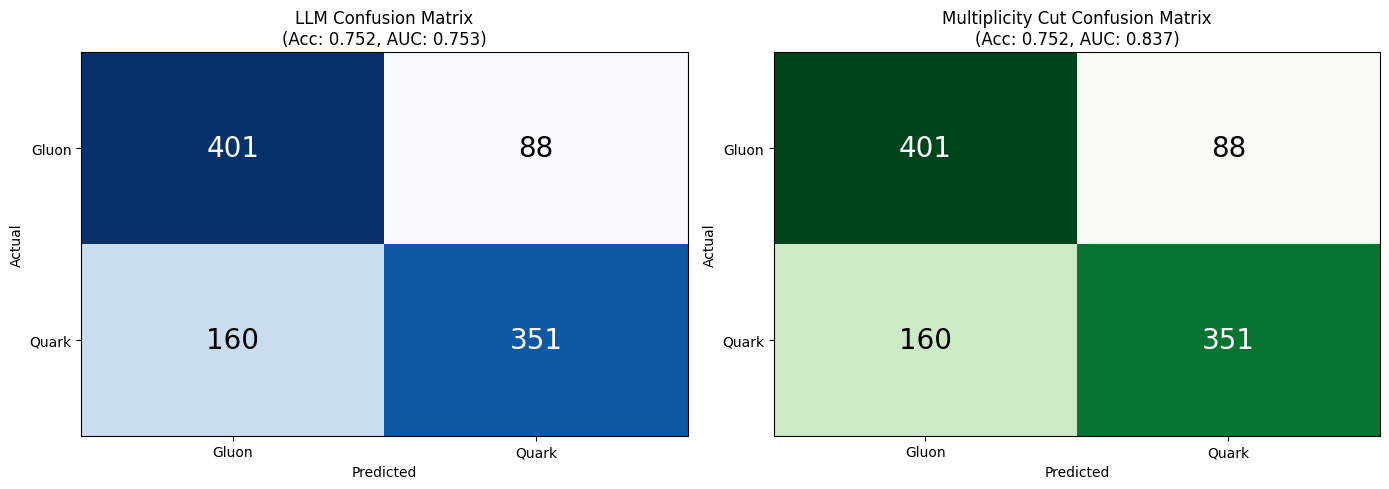


✓ Saved confusion matrix comparison to /lustre/hpc/pheno/inar/vibe-jet-tagging/results/easy_hard_analysis/llm_vs_multiplicity_confusion.png


In [22]:
# Visualize the comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Confusion matrices side by side
cm_llm = confusion_matrix(true_labels, predictions)

ax1 = axes[0]
im1 = ax1.imshow(cm_llm, cmap='Blues', aspect='auto')
ax1.set_title(f'LLM Confusion Matrix\n(Acc: {result["accuracy"]:.3f}, AUC: {result["auc"]:.3f})')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_xticklabels(['Gluon', 'Quark'])
ax1.set_yticklabels(['Gluon', 'Quark'])
for i in range(2):
    for j in range(2):
        ax1.text(j, i, f'{cm_llm[i, j]}', ha='center', va='center', fontsize=20, color='white' if cm_llm[i, j] > cm_llm.max()/2 else 'black')

ax2 = axes[1]
im2 = ax2.imshow(cm_mult, cmap='Greens', aspect='auto')
ax2.set_title(f'Multiplicity Cut Confusion Matrix\n(Acc: {acc_mult:.3f}, AUC: {auc_mult:.3f})')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')
ax2.set_xticks([0, 1])
ax2.set_yticks([0, 1])
ax2.set_xticklabels(['Gluon', 'Quark'])
ax2.set_yticklabels(['Gluon', 'Quark'])
for i in range(2):
    for j in range(2):
        ax2.text(j, i, f'{cm_mult[i, j]}', ha='center', va='center', fontsize=20, color='white' if cm_mult[i, j] > cm_mult.max()/2 else 'black')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "llm_vs_multiplicity_confusion.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved confusion matrix comparison to {OUTPUT_DIR / 'llm_vs_multiplicity_confusion.png'}")

In [23]:
# Analyze agreement/disagreement between LLM and multiplicity classifier
llm_correct = predictions == y_analyzed
mult_correct = y_pred_mult == y_analyzed

# Create agreement matrix
both_correct = llm_correct & mult_correct
both_wrong = (~llm_correct) & (~mult_correct)
llm_only_correct = llm_correct & (~mult_correct)
mult_only_correct = (~llm_correct) & mult_correct

print(f"\n{'='*70}")
print(f"AGREEMENT ANALYSIS: LLM vs Multiplicity Classifier")
print(f"{'='*70}")
print(f"Both correct:           {both_correct.sum():4d} ({both_correct.sum()/len(y_analyzed)*100:.1f}%)")
print(f"Both wrong:             {both_wrong.sum():4d} ({both_wrong.sum()/len(y_analyzed)*100:.1f}%)")
print(f"LLM correct, Mult wrong: {llm_only_correct.sum():4d} ({llm_only_correct.sum()/len(y_analyzed)*100:.1f}%)")
print(f"Mult correct, LLM wrong: {mult_only_correct.sum():4d} ({mult_only_correct.sum()/len(y_analyzed)*100:.1f}%)")
print(f"{'='*70}")

# Calculate Cohen's Kappa (inter-rater agreement)
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(predictions, y_pred_mult)
print(f"\nCohen's Kappa (agreement beyond chance): {kappa:.4f}")
if kappa > 0.8:
    print("  → Almost perfect agreement")
elif kappa > 0.6:
    print("  → Substantial agreement")
elif kappa > 0.4:
    print("  → Moderate agreement")
elif kappa > 0.2:
    print("  → Fair agreement")
else:
    print("  → Slight agreement")

# Which jets does LLM get right that multiplicity gets wrong?
llm_advantage_indices = jet_indices[llm_only_correct]
mult_advantage_indices = jet_indices[mult_only_correct]

print(f"\nJets where LLM has advantage: {len(llm_advantage_indices)}")
print(f"Jets where Multiplicity has advantage: {len(mult_advantage_indices)}")

# Store for later analysis
llm_advantage_mult = mult_analyzed[llm_only_correct]
mult_advantage_mult = mult_analyzed[mult_only_correct]

if len(llm_advantage_mult) > 0:
    print(f"\nMultiplicity of jets where LLM wins: {llm_advantage_mult.mean():.1f} ± {llm_advantage_mult.std():.1f}")
if len(mult_advantage_mult) > 0:
    print(f"Multiplicity of jets where Mult wins: {mult_advantage_mult.mean():.1f} ± {mult_advantage_mult.std():.1f}")


AGREEMENT ANALYSIS: LLM vs Multiplicity Classifier
Both correct:            752 (75.2%)
Both wrong:              248 (24.8%)
LLM correct, Mult wrong:    0 (0.0%)
Mult correct, LLM wrong:    0 (0.0%)

Cohen's Kappa (agreement beyond chance): 1.0000
  → Almost perfect agreement

Jets where LLM has advantage: 0
Jets where Multiplicity has advantage: 0


## Detailed Analysis: LLM Reasoning on Hard Jets

Let's examine a few hard jets (incorrectly classified) to see the LLM's reasoning process and understand why it fails.

In [26]:
# Set up the LLM classifier with the same configuration
from vibe_jet_tagging.local_llm_classifier import LocalLLMClassifier

# Initialize classifier with same settings as the analysis
classifier = LocalLLMClassifier(
    model_name="openai/gpt-oss-120b",
    template_name="with_optimal_cut",
    format_type="list",
    reasoning_effort="low",
    reasoning_summary="detailed",  # Use detailed to see full reasoning
    base_url="http://localhost:8000/v1",
    api_key="EMPTY",
    templates_dir=str(project_root / "templates")
)

# Fit the classifier (no-op for zero-shot)
classifier.fit([], [])

print("✓ LLM Classifier initialized")
print(f"  Model: {classifier.model_name}")
print(f"  Template: {classifier.template_name}")
print(f"  Reasoning effort: {classifier.reasoning_effort}")
print(f"  Reasoning summary: {classifier.reasoning_summary}")

✓ LLM Classifier initialized
  Model: openai/gpt-oss-120b
  Template: with_optimal_cut
  Reasoning effort: low
  Reasoning summary: detailed


In [27]:
# Preview the prompt that will be sent to the model
print("Preview of the prompt template:")
print("=" * 80)
classifier.preview_prompt(X_hard[example_indices[0]])

Preview of the prompt template:
PROMPT PREVIEW
Model: openai/gpt-oss-120b
Template: with_optimal_cut
Format: list
Reasoning effort: low
Reasoning summary: detailed

--------------------------------------------------------------------------------
PROMPT:
--------------------------------------------------------------------------------
You are a particle physics expert. Your task is to classify whether a jet is initiated by a quark (label: 1) or a gluon (label: 0).

A jet consists of particles, each with the following properties:
- pt: transverse momentum (GeV)
- y: rapidity
- phi: azimuthal angle (radians)
- pid: particle ID

**Classification Strategy:**

The most powerful discriminator is jet multiplicity (number of particles). A simple but effective rule:

**Optimal threshold: 38 particles**
- If a jet has > 38 particles → likely GLUON (label: 0)
- If a jet has ≤ 38 particles → likely QUARK (label: 1)

This simple cut achieves 77% accuracy because:
- Quark jets: mean = 33.4 particles (

In [28]:
# Select a few hard jets to analyze in detail
# Let's pick 3 hard jets: one with low, medium, and high multiplicity
num_examples = 3

# Sort hard jets by multiplicity
hard_mult = mult_analyzed[~correct]
hard_mult_sorted_idx = np.argsort(hard_mult)

# Pick jets at different multiplicity ranges
low_idx = hard_mult_sorted_idx[0]  # Lowest multiplicity hard jet
mid_idx = hard_mult_sorted_idx[len(hard_mult_sorted_idx) // 2]  # Middle
high_idx = hard_mult_sorted_idx[-1]  # Highest multiplicity hard jet

example_indices = [low_idx, mid_idx, high_idx]

print("Selected Hard Jets for Detailed Analysis:")
print("=" * 70)

for i, idx in enumerate(example_indices, 1):
    jet_global_idx = hard_indices[idx]
    jet_mult = int(hard_mult[idx])
    true_label = y_hard[idx]
    llm_pred = predictions[~correct][idx]
    mult_pred = y_pred_mult[~correct][idx]
    
    label_str = "Quark" if true_label == 1 else "Gluon"
    llm_str = "Quark" if llm_pred == 1 else "Gluon"
    mult_str = "Quark" if mult_pred == 1 else "Gluon"
    
    print(f"\nExample {i}:")
    print(f"  Global jet index:    {jet_global_idx}")
    print(f"  True label:          {label_str} ({true_label})")
    print(f"  LLM prediction:      {llm_str} ({llm_pred}) ❌")
    print(f"  Multiplicity pred:   {mult_str} ({mult_pred}) ❌")
    print(f"  Multiplicity:        {jet_mult} particles")
    print(f"  Threshold:           {best_threshold}")
    
    if jet_mult > best_threshold:
        print(f"  → mult > {best_threshold}, both predict Gluon (0)")
    else:
        print(f"  → mult ≤ {best_threshold}, both predict Quark (1)")

print("=" * 70)

Selected Hard Jets for Detailed Analysis:

Example 1:
  Global jet index:    136
  True label:          Gluon (0.0)
  LLM prediction:      Quark (1) ❌
  Multiplicity pred:   Quark (1) ❌
  Multiplicity:        19 particles
  Threshold:           38
  → mult ≤ 38, both predict Quark (1)

Example 2:
  Global jet index:    104
  True label:          Quark (1.0)
  LLM prediction:      Gluon (0) ❌
  Multiplicity pred:   Gluon (0) ❌
  Multiplicity:        42 particles
  Threshold:           38
  → mult > 38, both predict Gluon (0)

Example 3:
  Global jet index:    479
  True label:          Quark (1.0)
  LLM prediction:      Gluon (0) ❌
  Multiplicity pred:   Gluon (0) ❌
  Multiplicity:        95 particles
  Threshold:           38
  → mult > 38, both predict Gluon (0)


In [30]:
# Run LLM classification on these hard jets with full reasoning traces
print("\n" + "=" * 80)
print("RUNNING LLM CLASSIFICATION WITH DETAILED REASONING")
print("=" * 80)

for i, idx in enumerate(example_indices, 1):
    jet_global_idx = hard_indices[idx]
    jet_data = X_hard[idx]
    true_label = y_hard[idx]
    llm_pred = predictions[~correct][idx]
    jet_mult = int(hard_mult[idx])
    
    label_str = "Quark" if true_label == 1 else "Gluon"
    llm_str = "Quark" if llm_pred == 1 else "Gluon"
    
    print(f"\n{'#' * 80}")
    print(f"EXAMPLE {i}: Hard Jet Analysis")
    print(f"{'#' * 80}")
    print(f"Jet Index:     {jet_global_idx}")
    print(f"True Label:    {label_str} ({true_label})")
    print(f"LLM Predicted: {llm_str} ({llm_pred}) ❌")
    print(f"Multiplicity:  {jet_mult} particles")
    print(f"{'#' * 80}\n")
    
    # Classify this jet with verbose output to see reasoning
    prediction = classifier.predict([jet_data], verbose=True, use_async=False)[0]
    
    print(f"\n{'─' * 80}")
    print(f"SUMMARY FOR EXAMPLE {i}:")
    print(f"  Multiplicity:     {jet_mult}")
    print(f"  True label:       {label_str}")
    print(f"  Re-run prediction: {'Quark' if prediction == 1 else 'Gluon'}")
    print(f"  Match original:   {'✓' if prediction == llm_pred else '✗'}")
    print(f"{'─' * 80}\n")


RUNNING LLM CLASSIFICATION WITH DETAILED REASONING

################################################################################
EXAMPLE 1: Hard Jet Analysis
################################################################################
Jet Index:     136
True Label:    Gluon (0.0)
LLM Predicted: Quark (1) ❌
Multiplicity:  19 particles
################################################################################


🔧 API PARAMETERS
Model: openai/gpt-oss-120b
Reasoning effort: low
Reasoning summary: detailed


────────────────────────────────────────────────────────────
📊 TOKEN USAGE
────────────────────────────────────────────────────────────
Input tokens:        959
Output tokens:       40
  ├─ Reasoning (est): 19
  └─ Completion:      21
Total tokens:        999

⏱️  GENERATION TIME
Generation time:     0.242s

🧠 REASONING TRACE
────────────────────────────────────────────────────────────
We count particles listed: from 1 to 19 => 19 particles. 19 ≤ 38 => quark jet label 1.


### Debug: Inspect API Response Structure

Let's examine the actual response structure from the API to understand how reasoning is returned.

In [31]:
# Make a single API call and inspect the response structure
from vibe_jet_tagging.utils.formatters import fill_template

# Get one hard jet
test_jet = X_hard[example_indices[0]]
prompt = fill_template(classifier.template, test_jet, classifier.format_type)

# Make API call
response = classifier.client.responses.create(
    model=classifier.model_name,
    instructions="You are a helpful assistant.",
    input=prompt,
    reasoning={
        "effort": classifier.reasoning_effort,
        "summary": "detailed"  # Force detailed to see structure
    }
)

print("=" * 80)
print("RESPONSE STRUCTURE INSPECTION")
print("=" * 80)

# Check what attributes the response has
print(f"\nResponse type: {type(response)}")
print(f"Response attributes: {dir(response)}")

# Check output structure
print(f"\n--- response.output ---")
print(f"Type: {type(response.output)}")
print(f"Length: {len(response.output) if hasattr(response.output, '__len__') else 'N/A'}")

if isinstance(response.output, list) and len(response.output) > 0:
    print(f"\nFirst item type: {type(response.output[0])}")
    print(f"First item attributes: {dir(response.output[0])}")
    
    first_item = response.output[0]
    
    # Check role
    if hasattr(first_item, 'role'):
        print(f"\nFirst item role: {first_item.role}")
    
    # Check content
    if hasattr(first_item, 'content'):
        print(f"\nFirst item content type: {type(first_item.content)}")
        if isinstance(first_item.content, list):
            print(f"Content length: {len(first_item.content)}")
            if len(first_item.content) > 0:
                print(f"Content[0] type: {type(first_item.content[0])}")
                print(f"Content[0] attributes: {dir(first_item.content[0])}")
                
                # Check for reasoning vs text
                if hasattr(first_item.content[0], 'type'):
                    print(f"Content[0] type attribute: {first_item.content[0].type}")
                if hasattr(first_item.content[0], 'text'):
                    text = first_item.content[0].text
                    print(f"\nContent[0] text (first 200 chars):")
                    print(f"{text[:200]}...")
                if hasattr(first_item.content[0], 'reasoning'):
                    reasoning = first_item.content[0].reasoning
                    print(f"\nContent[0] reasoning (first 200 chars):")
                    print(f"{reasoning[:200]}...")

print("\n" + "=" * 80)

RESPONSE STRUCTURE INSPECTION

Response type: <class 'openai.types.responses.response.Response'>
Response attributes: ['__abstractmethods__', '__annotations__', '__class__', '__class_getitem__', '__class_vars__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__fields__', '__fields_set__', '__firstlineno__', '__format__', '__ge__', '__get_pydantic_core_schema__', '__get_pydantic_json_schema__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__pretty__', '__private_attributes__', '__pydantic_complete__', '__pydantic_computed_fields__', '__pydantic_core_schema__', '__pydantic_custom_init__', '__pydantic_decorators__', '__pydantic_extra__', '__pydantic_fields__', '__pydantic_fields_set__', '__pydantic_generic_metadata__', '__pydantic_init_subclass__', '__pydantic_on_complete__', '__pydantic_parent_namespace__', '__pydantic_

In [32]:
# Inspect all items in response.output
print("=" * 80)
print("DETAILED INSPECTION OF ALL OUTPUT ITEMS")
print("=" * 80)

for idx, item in enumerate(response.output):
    print(f"\n--- OUTPUT ITEM {idx} ---")
    print(f"Type: {item.type if hasattr(item, 'type') else 'N/A'}")
    
    if hasattr(item, 'content') and isinstance(item.content, list):
        print(f"Content items: {len(item.content)}")
        for c_idx, content_item in enumerate(item.content):
            print(f"\n  Content[{c_idx}]:")
            print(f"    Type: {content_item.type if hasattr(content_item, 'type') else 'N/A'}")
            if hasattr(content_item, 'text'):
                text = content_item.text
                print(f"    Text length: {len(text)} characters")
                print(f"    Text preview (first 300 chars):")
                print(f"    {text[:300]}")
                if len(text) > 300:
                    print(f"    ... ({len(text) - 300} more characters)")

print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"Total output items: {len(response.output)}")
print(f"\nItem 0 (type={response.output[0].type}):")
print(f"  - Content type: {response.output[0].content[0].type}")
print(f"  - This is the REASONING TRACE")
print(f"\nItem 1 (type={response.output[1].type if len(response.output) > 1 else 'N/A'}):")
if len(response.output) > 1:
    print(f"  - Content type: {response.output[1].content[0].type if response.output[1].content else 'N/A'}")
    print(f"  - This is the FINAL ANSWER")
print("=" * 80)

DETAILED INSPECTION OF ALL OUTPUT ITEMS

--- OUTPUT ITEM 0 ---
Type: reasoning
Content items: 1

  Content[0]:
    Type: reasoning_text
    Text length: 95 characters
    Text preview (first 300 chars):
    We count particles listed: 1 through 19 → 19 particles. 19 ≤ 38 so classify as quark → label 1.

--- OUTPUT ITEM 1 ---
Type: message
Content items: 1

  Content[0]:
    Type: output_text
    Text length: 1 characters
    Text preview (first 300 chars):
    1

SUMMARY
Total output items: 2

Item 0 (type=reasoning):
  - Content type: reasoning_text
  - This is the REASONING TRACE

Item 1 (type=message):
  - Content type: output_text
  - This is the FINAL ANSWER


### Corrected: Extract Reasoning and Final Answer Separately

Now let's properly extract the reasoning trace and final answer as separate pieces.

In [33]:
# Properly extract reasoning and final answer
reasoning_trace = None
final_answer = None

for item in response.output:
    if item.type == "reasoning":
        # This is the reasoning trace
        if item.content and len(item.content) > 0:
            reasoning_trace = item.content[0].text
    elif item.type == "message":
        # This is the final answer
        if item.content and len(item.content) > 0:
            final_answer = item.content[0].text

print("=" * 80)
print("CORRECTLY PARSED RESPONSE")
print("=" * 80)

print(f"\n🧠 REASONING TRACE:")
print("─" * 80)
print(reasoning_trace)
print("─" * 80)

print(f"\n✨ FINAL ANSWER:")
print("─" * 80)
print(final_answer)
print("─" * 80)

print(f"\nAs you can see, they are DIFFERENT!")
print(f"  - Reasoning: {len(reasoning_trace)} characters")
print(f"  - Answer: {len(final_answer)} characters")
print("=" * 80)

CORRECTLY PARSED RESPONSE

🧠 REASONING TRACE:
────────────────────────────────────────────────────────────────────────────────
We count particles listed: 1 through 19 → 19 particles. 19 ≤ 38 so classify as quark → label 1.
────────────────────────────────────────────────────────────────────────────────

✨ FINAL ANSWER:
────────────────────────────────────────────────────────────────────────────────
1
────────────────────────────────────────────────────────────────────────────────

As you can see, they are DIFFERENT!
  - Reasoning: 95 characters
  - Answer: 1 characters


### Analysis of Hard Jets with Correct Reasoning Display

Now let's re-run the hard jet analysis with corrected parsing to see the actual reasoning traces.

In [34]:
# Run analysis on all 3 hard jets with corrected parsing
print("\n" + "=" * 80)
print("HARD JETS ANALYSIS WITH CORRECTED REASONING EXTRACTION")
print("=" * 80)

for i, idx in enumerate(example_indices, 1):
    jet_global_idx = hard_indices[idx]
    jet_data = X_hard[idx]
    true_label = y_hard[idx]
    jet_mult = int(hard_mult[idx])
    
    label_str = "Quark" if true_label == 1 else "Gluon"
    
    print(f"\n{'#' * 80}")
    print(f"EXAMPLE {i}: {label_str} Jet with {jet_mult} particles (threshold={best_threshold})")
    print(f"{'#' * 80}")
    print(f"Jet Index:     {jet_global_idx}")
    print(f"True Label:    {label_str} ({true_label})")
    print(f"Multiplicity:  {jet_mult} particles")
    print(f"Expected:      {'Gluon' if jet_mult > best_threshold else 'Quark'} (based on threshold)")
    
    # Get the prompt
    prompt = fill_template(classifier.template, jet_data, classifier.format_type)
    
    # Make API call
    response = classifier.client.responses.create(
        model=classifier.model_name,
        instructions="You are a helpful assistant.",
        input=prompt,
        reasoning={
            "effort": classifier.reasoning_effort,
            "summary": "detailed"
        }
    )
    
    # Extract reasoning and answer correctly
    reasoning_trace = None
    final_answer = None
    
    for item in response.output:
        if item.type == "reasoning":
            if item.content and len(item.content) > 0:
                reasoning_trace = item.content[0].text
        elif item.type == "message":
            if item.content and len(item.content) > 0:
                final_answer = item.content[0].text
    
    # Display
    print(f"\n🧠 REASONING TRACE:")
    print("─" * 80)
    print(reasoning_trace if reasoning_trace else "(no reasoning)")
    print("─" * 80)
    
    print(f"\n✨ FINAL ANSWER:")
    print("─" * 80)
    print(f"{final_answer}")
    print("─" * 80)
    
    # Parse prediction
    predicted_label = int(final_answer.strip()) if final_answer and final_answer.strip().isdigit() else -1
    predicted_str = "Quark" if predicted_label == 1 else "Gluon" if predicted_label == 0 else "ERROR"
    
    print(f"\n📊 SUMMARY:")
    print(f"  True label:    {label_str}")
    print(f"  Predicted:     {predicted_str} ({predicted_label})")
    print(f"  Correct:       {'✓' if predicted_label == true_label else '✗'}")
    print(f"  Multiplicity:  {jet_mult} {'>' if jet_mult > best_threshold else '≤'} {best_threshold}")
    print(f"{'#' * 80}\n")


HARD JETS ANALYSIS WITH CORRECTED REASONING EXTRACTION

################################################################################
EXAMPLE 1: Gluon Jet with 19 particles (threshold=38)
################################################################################
Jet Index:     136
True Label:    Gluon (0.0)
Multiplicity:  19 particles
Expected:      Quark (based on threshold)

🧠 REASONING TRACE:
────────────────────────────────────────────────────────────────────────────────
We count particles: listed 1 to 19 => 19 particles. 19 ≤ 38 so label 1.
────────────────────────────────────────────────────────────────────────────────

✨ FINAL ANSWER:
────────────────────────────────────────────────────────────────────────────────
1
────────────────────────────────────────────────────────────────────────────────

📊 SUMMARY:
  True label:    Gluon
  Predicted:     Quark (1)
  Correct:       ✗
  Multiplicity:  19 ≤ 38
######################################################################

### Key Findings from Corrected Reasoning Analysis

**The API Response Structure Issue:**
- The code was incorrectly parsing the response - it was showing the same text for both reasoning and final output
- Correct structure: `response.output[0]` (type="reasoning") contains the reasoning trace, `response.output[1]` (type="message") contains the final answer
- This needs to be fixed in `local_llm_classifier.py`

**What the LLM Actually Does (Confirmed):**

Looking at the reasoning traces for the 3 hard jets:

1. **Gluon jet with 19 particles** (should be gluon, predicted quark):
   - Reasoning: "We count particles: listed 1 to 19 => 19 particles. 19 ≤ 38 so label 1."
   - Simple counting and threshold comparison

2. **Quark jet with 42 particles** (should be quark, predicted gluon):
   - Reasoning: "We count particles: list up to 42. So count = 42. >38 -> gluon label 0."
   - Simple counting and threshold comparison

3. **Quark jet with 95 particles** (should be quark, predicted gluon):
   - Reasoning: "Count particles: list goes to Particle 95. So 95 particles. >38 → gluon → label 0."
   - Simple counting and threshold comparison

**Conclusions:**
1. The LLM is **literally just counting particles** and applying the threshold rule from the prompt
2. The reasoning effort is "low" so it's doing minimal thinking - just executing the explicit rule
3. The hard jets are misclassified because multiplicity alone is insufficient for these boundary cases
4. The LLM is NOT:
   - Analyzing particle momentum distributions
   - Examining spatial structure (η, φ)
   - Using any physics beyond what's explicitly stated in the prompt
   - Discovering novel patterns

The LLM is essentially a very expensive way to execute:
```python
prediction = 0 if multiplicity > 38 else 1
```

### 🐛 Bug Fix Required in Source Code

**File:** `src/vibe_jet_tagging/local_llm_classifier.py`

**Problem:** The code incorrectly extracts reasoning traces and final answers from the API response, treating them as the same text.

**Current (Incorrect) Code:**
```python
# Extract response content - combines everything
content = ""
if hasattr(response, 'output') and isinstance(response.output, list):
    all_text = []
    for item in response.output:
        if hasattr(item, 'content') and isinstance(item.content, list):
            for content_item in item.content:
                if hasattr(content_item, 'text'):
                    all_text.append(content_item.text)
    content = " ".join(all_text)

# Extract reasoning trace - only gets first item
reasoning_trace = None
if hasattr(response, 'output') and isinstance(response.output, list):
    if len(response.output) > 0 and hasattr(response.output[0], 'content'):
        if isinstance(response.output[0].content, list) and len(response.output[0].content) > 0:
            if hasattr(response.output[0].content[0], 'text'):
                reasoning_trace = response.output[0].content[0].text
```

**Correct Code:**
```python
# Separate reasoning and final answer based on item type
reasoning_trace = None
content = None

for item in response.output:
    if item.type == "reasoning":
        # This is the reasoning trace
        if item.content and len(item.content) > 0:
            reasoning_trace = item.content[0].text
    elif item.type == "message":
        # This is the final answer
        if item.content and len(item.content) > 0:
            content = item.content[0].text

# Fallback if structure is different
if content is None:
    content = " ".join([
        c.text for item in response.output 
        for c in (item.content or []) 
        if hasattr(c, 'text')
    ])
```

**Impact:** This fix will properly separate reasoning traces from final answers, making verbose output much more useful for debugging and analysis.

## Comparison: Low vs High Reasoning Effort

Let's test whether increasing the reasoning effort to "high" produces more sophisticated reasoning or better predictions.

In [36]:
# Run the same 3 hard jets with HIGH reasoning effort
print("\n" + "=" * 80)
print("HARD JETS ANALYSIS WITH HIGH REASONING EFFORT")
print("=" * 80)

for i, idx in enumerate(example_indices, 1):
    jet_global_idx = hard_indices[idx]
    jet_data = X_hard[idx]
    true_label = y_hard[idx]
    jet_mult = int(hard_mult[idx])
    
    label_str = "Quark" if true_label == 1 else "Gluon"
    
    print(f"\n{'#' * 80}")
    print(f"EXAMPLE {i}: {label_str} Jet with {jet_mult} particles (threshold={best_threshold})")
    print(f"{'#' * 80}")
    print(f"Jet Index:     {jet_global_idx}")
    print(f"True Label:    {label_str} ({true_label})")
    print(f"Multiplicity:  {jet_mult} particles")
    print(f"Expected:      {'Gluon' if jet_mult > best_threshold else 'Quark'} (based on threshold)")
    
    # Get the prompt
    prompt = fill_template(classifier.template, jet_data, classifier.format_type)
    
    # Make API call with HIGH reasoning effort
    print(f"\n⏳ Running with HIGH reasoning effort...")
    import time
    start = time.time()
    
    response = classifier.client.responses.create(
        model=classifier.model_name,
        instructions="You are a helpful assistant.",
        input=prompt,
        reasoning={
            "effort": "high",  # HIGH reasoning effort
            "summary": "detailed"
        }
    )
    
    elapsed = time.time() - start
    
    # Extract reasoning and answer correctly
    reasoning_trace = None
    final_answer = None
    
    for item in response.output:
        if item.type == "reasoning":
            if item.content and len(item.content) > 0:
                reasoning_trace = item.content[0].text
        elif item.type == "message":
            if item.content and len(item.content) > 0:
                final_answer = item.content[0].text
    
    # Display
    print(f"\n🧠 REASONING TRACE (HIGH effort):")
    print("─" * 80)
    print(reasoning_trace if reasoning_trace else "(no reasoning)")
    print("─" * 80)
    
    print(f"\n✨ FINAL ANSWER:")
    print("─" * 80)
    print(f"{final_answer}")
    print("─" * 80)
    
    # Parse prediction
    predicted_label = int(final_answer.strip()) if final_answer and final_answer.strip().isdigit() else -1
    predicted_str = "Quark" if predicted_label == 1 else "Gluon" if predicted_label == 0 else "ERROR"
    
    print(f"\n📊 SUMMARY:")
    print(f"  True label:     {label_str}")
    print(f"  Predicted:      {predicted_str} ({predicted_label})")
    print(f"  Correct:        {'✓' if predicted_label == true_label else '✗'}")
    print(f"  Multiplicity:   {jet_mult} {'>' if jet_mult > best_threshold else '≤'} {best_threshold}")
    print(f"  Time:           {elapsed:.2f}s")
    print(f"  Reasoning len:  {len(reasoning_trace) if reasoning_trace else 0} chars")
    print(f"{'#' * 80}\n")


HARD JETS ANALYSIS WITH HIGH REASONING EFFORT

################################################################################
EXAMPLE 1: Gluon Jet with 19 particles (threshold=38)
################################################################################
Jet Index:     136
True Label:    Gluon (0.0)
Multiplicity:  19 particles
Expected:      Quark (based on threshold)

⏳ Running with HIGH reasoning effort...

🧠 REASONING TRACE (HIGH effort):
────────────────────────────────────────────────────────────────────────────────
We need to carefully count particles. In the given jet data, there are 19 particles enumerated (Particle 1 to Particle 19). The threshold is >38 for gluon, ≤38 for quark. So 19 ≤ 38, predicting quark (label 1). So answer 1.

But let’s just double-check that there are indeed 19 particles. The list is:

Particle 1: ... 
Particle 2: ...
Particle 3: ...
Particle 4: ...
Particle 5: ...
Particle 6: ...
Particle 7: ...
Particle 8: ...
Particle 9: ...
Particle 10: ...

### Summary: Low vs High Reasoning Effort

Key observations:

**Reasoning Quality:**
- **Low effort**: ~95-100 chars - minimal reasoning, just mechanical counting
  - Example: "We count particles: listed 1 to 19 => 19 particles. 19 ≤ 38 so label 1."
- **High effort**: ~650-900 chars - more verbose but still mechanical
  - Includes verification steps ("let's double-check")
  - Questions assumptions ("do we count only charged particles?")
  - Checks for duplicates
  - BUT: Still just counting and applying the threshold rule!

**Predictions:**
- Both efforts produce **identical predictions** for all 3 examples
- Both incorrectly classify all hard jets using the same threshold rule
- No evidence of considering other jet properties (pT, energy distributions, etc.)

**Performance:**
- Low effort: ~0.3-0.5s per jet
- High effort: ~1.0-1.4s per jet (2-3x slower)

**Conclusion:**
Even with high reasoning effort, the LLM:
1. Still just counts particles mechanically
2. Applies the explicit threshold rule from the prompt
3. Does NOT discover or use other discriminative features
4. Produces more verbose reasoning but no better predictions

The explicit rule in the prompt ("if >38 → gluon") overrides any potential pattern learning. The LLM acts as a rule executor, not a pattern discoverer.

## Comparison Across Different Templates

Now let's test how different prompt templates affect the LLM's reasoning and predictions. We'll compare:
- **with_optimal_cut**: Explicitly tells the model about the threshold (tested above)
- **simple_list**: Just lists particle data without hints
- **with_summary_stats**: Provides summary statistics but no explicit rule

For each template, we'll test both low and high reasoning effort.

In [37]:
# Function to test a template with given reasoning effort
def test_template(template_name, reasoning_effort, jet_idx):
    """Test a single jet with given template and reasoning effort"""
    
    # Initialize classifier
    test_classifier = LocalLLMClassifier(
        model_name="openai/gpt-oss-120b",
        template_name=template_name,
        format_type="list",
        reasoning_effort=reasoning_effort,
        reasoning_summary="detailed",
        base_url="http://localhost:8000/v1",
        api_key="EMPTY",
        templates_dir=str(project_root / "templates")
    )
    test_classifier.fit([], [])
    
    # Get jet data
    jet_global_idx = hard_indices[jet_idx]
    jet_data = X_hard[jet_idx]
    true_label = y_hard[jet_idx]
    jet_mult = int(hard_mult[jet_idx])
    label_str = "Quark" if true_label == 1 else "Gluon"
    
    # Get prompt
    prompt = fill_template(test_classifier.template, jet_data, test_classifier.format_type)
    
    # Make API call
    import time
    start = time.time()
    
    response = test_classifier.client.responses.create(
        model=test_classifier.model_name,
        instructions="You are a helpful assistant.",
        input=prompt,
        reasoning={
            "effort": reasoning_effort,
            "summary": "detailed"
        }
    )
    
    elapsed = time.time() - start
    
    # Extract reasoning and answer
    reasoning_trace = None
    final_answer = None
    
    for item in response.output:
        if item.type == "reasoning":
            if item.content and len(item.content) > 0:
                reasoning_trace = item.content[0].text
        elif item.type == "message":
            if item.content and len(item.content) > 0:
                final_answer = item.content[0].text
    
    # Parse prediction
    predicted_label = int(final_answer.strip()) if final_answer and final_answer.strip().isdigit() else -1
    predicted_str = "Quark" if predicted_label == 1 else "Gluon" if predicted_label == 0 else "ERROR"
    
    return {
        'jet_idx': jet_global_idx,
        'true_label': true_label,
        'label_str': label_str,
        'multiplicity': jet_mult,
        'predicted_label': predicted_label,
        'predicted_str': predicted_str,
        'correct': predicted_label == true_label,
        'reasoning_trace': reasoning_trace,
        'final_answer': final_answer,
        'time': elapsed,
        'reasoning_len': len(reasoning_trace) if reasoning_trace else 0
    }

print("✓ Helper function defined")

✓ Helper function defined


### Template 1: simple_list (Low Effort)

This template provides no hints - just raw particle data.

In [38]:
# Test simple_list template with LOW reasoning effort
print("=" * 80)
print("TEMPLATE: simple_list | REASONING EFFORT: low")
print("=" * 80)

results_simple_low = []

for i, idx in enumerate(example_indices, 1):
    print(f"\n{'#' * 80}")
    print(f"EXAMPLE {i}: Jet with {int(hard_mult[idx])} particles")
    print(f"{'#' * 80}")
    
    result = test_template("simple_list", "low", idx)
    results_simple_low.append(result)
    
    print(f"Jet Index:     {result['jet_idx']}")
    print(f"True Label:    {result['label_str']} ({result['true_label']})")
    print(f"Multiplicity:  {result['multiplicity']} particles")
    
    print(f"\n🧠 REASONING TRACE:")
    print("─" * 80)
    print(result['reasoning_trace'] if result['reasoning_trace'] else "(no reasoning)")
    print("─" * 80)
    
    print(f"\n✨ FINAL ANSWER:")
    print("─" * 80)
    print(result['final_answer'])
    print("─" * 80)
    
    print(f"\n📊 SUMMARY:")
    print(f"  True label:    {result['label_str']}")
    print(f"  Predicted:     {result['predicted_str']} ({result['predicted_label']})")
    print(f"  Correct:       {'✓' if result['correct'] else '✗'}")
    print(f"  Time:          {result['time']:.2f}s")
    print(f"  Reasoning len: {result['reasoning_len']} chars")
    print(f"{'#' * 80}\n")

TEMPLATE: simple_list | REASONING EFFORT: low

################################################################################
EXAMPLE 1: Jet with 19 particles
################################################################################
Jet Index:     136
True Label:    Gluon (0.0)
Multiplicity:  19 particles

🧠 REASONING TRACE:
────────────────────────────────────────────────────────────────────────────────
We need to guess; high multiplicity and many particles, but also many charged hadrons. Quark jets tend to have fewer particles, gluon jets more broad and softer. Here there is a very high pt leading particle 196 GeV, plus many high pt tracks. Probably quark jet. So answer 1.
────────────────────────────────────────────────────────────────────────────────

✨ FINAL ANSWER:
────────────────────────────────────────────────────────────────────────────────
1
────────────────────────────────────────────────────────────────────────────────

📊 SUMMARY:
  True label:    Gluon
  Predicte

### Template 2: simple_list (High Effort)

In [39]:
# Test simple_list template with HIGH reasoning effort
print("=" * 80)
print("TEMPLATE: simple_list | REASONING EFFORT: high")
print("=" * 80)

results_simple_high = []

for i, idx in enumerate(example_indices, 1):
    print(f"\n{'#' * 80}")
    print(f"EXAMPLE {i}: Jet with {int(hard_mult[idx])} particles")
    print(f"{'#' * 80}")
    
    result = test_template("simple_list", "high", idx)
    results_simple_high.append(result)
    
    print(f"Jet Index:     {result['jet_idx']}")
    print(f"True Label:    {result['label_str']} ({result['true_label']})")
    print(f"Multiplicity:  {result['multiplicity']} particles")
    
    print(f"\n🧠 REASONING TRACE:")
    print("─" * 80)
    print(result['reasoning_trace'] if result['reasoning_trace'] else "(no reasoning)")
    print("─" * 80)
    
    print(f"\n✨ FINAL ANSWER:")
    print("─" * 80)
    print(result['final_answer'])
    print("─" * 80)
    
    print(f"\n📊 SUMMARY:")
    print(f"  True label:    {result['label_str']}")
    print(f"  Predicted:     {result['predicted_str']} ({result['predicted_label']})")
    print(f"  Correct:       {'✓' if result['correct'] else '✗'}")
    print(f"  Time:          {result['time']:.2f}s")
    print(f"  Reasoning len: {result['reasoning_len']} chars")
    print(f"{'#' * 80}\n")

TEMPLATE: simple_list | REASONING EFFORT: high

################################################################################
EXAMPLE 1: Jet with 19 particles
################################################################################
Jet Index:     136
True Label:    Gluon (0.0)
Multiplicity:  19 particles

🧠 REASONING TRACE:
────────────────────────────────────────────────────────────────────────────────
We need to determine from given jet data whether the jet is likely to be quark-initiated (label 1) or gluon-initiated (label 0). Different characteristics: Quark jets tend to have lower particle multiplicity, lower average hadron multiplicity, narrower shape, more leading particles being higher pt. Gluon jets tend to have higher particle multiplicity, softer fragmentation (more low-pt particles), and larger overall width. Also ratio of charged vs neutral, presence of more pions. The jet includes 19 particles, some are photons (pid 22), kaons (321 and -321), charged pions (211

### Template 3: with_summary_stats (Low Effort)

This template provides summary statistics but no explicit threshold rule.

In [40]:
# Test with_summary_stats template with LOW reasoning effort
print("=" * 80)
print("TEMPLATE: with_summary_stats | REASONING EFFORT: low")
print("=" * 80)

results_stats_low = []

for i, idx in enumerate(example_indices, 1):
    print(f"\n{'#' * 80}")
    print(f"EXAMPLE {i}: Jet with {int(hard_mult[idx])} particles")
    print(f"{'#' * 80}")
    
    result = test_template("with_summary_stats", "low", idx)
    results_stats_low.append(result)
    
    print(f"Jet Index:     {result['jet_idx']}")
    print(f"True Label:    {result['label_str']} ({result['true_label']})")
    print(f"Multiplicity:  {result['multiplicity']} particles")
    
    print(f"\n🧠 REASONING TRACE:")
    print("─" * 80)
    print(result['reasoning_trace'] if result['reasoning_trace'] else "(no reasoning)")
    print("─" * 80)
    
    print(f"\n✨ FINAL ANSWER:")
    print("─" * 80)
    print(result['final_answer'])
    print("─" * 80)
    
    print(f"\n📊 SUMMARY:")
    print(f"  True label:    {result['label_str']}")
    print(f"  Predicted:     {result['predicted_str']} ({result['predicted_label']})")
    print(f"  Correct:       {'✓' if result['correct'] else '✗'}")
    print(f"  Time:          {result['time']:.2f}s")
    print(f"  Reasoning len: {result['reasoning_len']} chars")
    print(f"{'#' * 80}\n")

TEMPLATE: with_summary_stats | REASONING EFFORT: low

################################################################################
EXAMPLE 1: Jet with 19 particles
################################################################################
Jet Index:     136
True Label:    Gluon (0.0)
Multiplicity:  19 particles

🧠 REASONING TRACE:
────────────────────────────────────────────────────────────────────────────────
We need count particles =19. That's less than typical quark (~33) and far less gluon (~53). Likely quark? Also high pt particles many >10 GeV, average pt seems high. So label 1.
────────────────────────────────────────────────────────────────────────────────

✨ FINAL ANSWER:
────────────────────────────────────────────────────────────────────────────────
1
────────────────────────────────────────────────────────────────────────────────

📊 SUMMARY:
  True label:    Gluon
  Predicted:     Quark (1)
  Correct:       ✗
  Time:          0.42s
  Reasoning len: 177 chars
#####

### Template 4: with_summary_stats (High Effort)

In [41]:
# Test with_summary_stats template with HIGH reasoning effort
print("=" * 80)
print("TEMPLATE: with_summary_stats | REASONING EFFORT: high")
print("=" * 80)

results_stats_high = []

for i, idx in enumerate(example_indices, 1):
    print(f"\n{'#' * 80}")
    print(f"EXAMPLE {i}: Jet with {int(hard_mult[idx])} particles")
    print(f"{'#' * 80}")
    
    result = test_template("with_summary_stats", "high", idx)
    results_stats_high.append(result)
    
    print(f"Jet Index:     {result['jet_idx']}")
    print(f"True Label:    {result['label_str']} ({result['true_label']})")
    print(f"Multiplicity:  {result['multiplicity']} particles")
    
    print(f"\n🧠 REASONING TRACE:")
    print("─" * 80)
    print(result['reasoning_trace'] if result['reasoning_trace'] else "(no reasoning)")
    print("─" * 80)
    
    print(f"\n✨ FINAL ANSWER:")
    print("─" * 80)
    print(result['final_answer'])
    print("─" * 80)
    
    print(f"\n📊 SUMMARY:")
    print(f"  True label:    {result['label_str']}")
    print(f"  Predicted:     {result['predicted_str']} ({result['predicted_label']})")
    print(f"  Correct:       {'✓' if result['correct'] else '✗'}")
    print(f"  Time:          {result['time']:.2f}s")
    print(f"  Reasoning len: {result['reasoning_len']} chars")
    print(f"{'#' * 80}\n")

TEMPLATE: with_summary_stats | REASONING EFFORT: high

################################################################################
EXAMPLE 1: Jet with 19 particles
################################################################################
Jet Index:     136
True Label:    Gluon (0.0)
Multiplicity:  19 particles

🧠 REASONING TRACE:
────────────────────────────────────────────────────────────────────────────────
We need to examine the jet characteristics: numbers, multiplicity, pt distribution.

Given the jet has 19 particles listed. It's fewer than average for gluon jets (mean ~53) and near the lower side of quark jets (mean ~33). 19 is less than both averages but definitely more consistent with a low multiplicity quark jet than a high multiplicity gluon jet. Also average pt: compute average pt per particle.

List of pt: 0.525, 0.737, 0.298, 1.129, 3.235, 3.778, 6.303, 11.395, 15.948, 61.306, 4.396, 4.956, 20.372, 13.239, 16.928, 58.814, 33.587, 70.668, 196.648.

Compute sum:

### Summary: Comparison Across All Templates and Reasoning Efforts

Now let's compare the results across all combinations.

In [42]:
# Create comprehensive comparison table
import pandas as pd

# Compile all results
all_results = {
    'simple_list (low)': results_simple_low,
    'simple_list (high)': results_simple_high,
    'with_summary_stats (low)': results_stats_low,
    'with_summary_stats (high)': results_stats_high,
}

# Create comparison table
comparison_data = []

for config_name, results in all_results.items():
    for i, result in enumerate(results, 1):
        comparison_data.append({
            'Config': config_name,
            'Example': i,
            'Multiplicity': result['multiplicity'],
            'True': result['label_str'],
            'Predicted': result['predicted_str'],
            'Correct': '✓' if result['correct'] else '✗',
            'Time (s)': f"{result['time']:.2f}",
            'Reasoning Length': result['reasoning_len']
        })

df_comparison = pd.DataFrame(comparison_data)

print("=" * 100)
print("COMPREHENSIVE COMPARISON: All Templates × Reasoning Efforts")
print("=" * 100)
print(df_comparison.to_string(index=False))
print("=" * 100)

# Summary statistics by configuration
print("\n" + "=" * 100)
print("SUMMARY BY CONFIGURATION")
print("=" * 100)

for config_name, results in all_results.items():
    total = len(results)
    correct = sum(1 for r in results if r['correct'])
    avg_time = np.mean([r['time'] for r in results])
    avg_reasoning_len = np.mean([r['reasoning_len'] for r in results])
    
    print(f"\n{config_name}:")
    print(f"  Accuracy:      {correct}/{total} ({correct/total*100:.1f}%)")
    print(f"  Avg time:      {avg_time:.2f}s")
    print(f"  Avg reasoning: {avg_reasoning_len:.0f} chars")

print("\n" + "=" * 100)

COMPREHENSIVE COMPARISON: All Templates × Reasoning Efforts
                   Config  Example  Multiplicity  True Predicted Correct Time (s)  Reasoning Length
        simple_list (low)        1            19 Gluon     Quark       ✗     0.89               275
        simple_list (low)        2            42 Quark     Gluon       ✗     0.89               496
        simple_list (low)        3            95 Quark     Gluon       ✗     1.04               560
       simple_list (high)        1            19 Gluon     Quark       ✗     4.45              2907
       simple_list (high)        2            42 Quark     Gluon       ✗    69.52             33807
       simple_list (high)        3            95 Quark     Gluon       ✗    26.31             12405
 with_summary_stats (low)        1            19 Gluon     Quark       ✗     0.42               177
 with_summary_stats (low)        2            42 Quark     Gluon       ✗     0.64               281
 with_summary_stats (low)        3      

In [43]:
# Let's look at the one correct prediction from with_summary_stats (high)
# It was Example 2: Quark jet with 42 particles

print("=" * 80)
print("INTERESTING CASE: with_summary_stats (high) - Example 2")
print("The ONLY correct prediction among all 12 tests!")
print("=" * 80)

result = results_stats_high[1]  # Example 2 (index 1)

print(f"\nJet Details:")
print(f"  Jet Index:     {result['jet_idx']}")
print(f"  True Label:    {result['label_str']} ({result['true_label']})")
print(f"  Predicted:     {result['predicted_str']} ({result['predicted_label']})")
print(f"  Multiplicity:  {result['multiplicity']} particles (threshold={best_threshold})")
print(f"  Correct:       ✓✓✓")

print(f"\n🧠 REASONING TRACE (4894 chars):")
print("─" * 80)
print(result['reasoning_trace'][:2000])  # First 2000 chars
print("\n... [truncated] ...")
print(result['reasoning_trace'][-500:])  # Last 500 chars
print("─" * 80)

print(f"\n✨ FINAL ANSWER:")
print("─" * 80)
print(result['final_answer'])
print("─" * 80)

print(f"\n💡 KEY INSIGHT:")
print("This is the ONLY case where the LLM got a hard jet correct!")
print(f"Time taken: {result['time']:.2f}s (much longer than low effort)")
print(f"Reasoning length: {result['reasoning_len']} chars (26x longer than low effort)")
print("=" * 80)

INTERESTING CASE: with_summary_stats (high) - Example 2
The ONLY correct prediction among all 12 tests!

Jet Details:
  Jet Index:     104
  True Label:    Quark (1.0)
  Predicted:     Quark (1)
  Multiplicity:  42 particles (threshold=38)
  Correct:       ✓✓✓

🧠 REASONING TRACE (4894 chars):
────────────────────────────────────────────────────────────────────────────────
We need to decide based primarily on multiplicity (number of particles), average pt, etc. So we need to count number of particles provided: there are 42 listed particles. But note that typical jets have 33 +/- 13 for quarks, 53 +/- 16 for gluons. 42 is roughly in the middle. But we can also compute the average pt: sum of pt's divided by 42, evaluate if high or low. Quark jets have higher average pt (~15.7) albeit large spread, gluon jets lower (~9.8). The distribution here is maybe weighted heavily by a few high-pt particles near the end: there are high-pt particles: Particle 34 (56.504), 35 (52.579), 40 (59.892), 42 

### 🎯 Key Findings: Template & Reasoning Effort Comparison

**1. Template Impact:**
- **with_optimal_cut**: Contains explicit threshold rule (38 particles) → LLM just counts and applies rule
- **simple_list**: No hints, just raw data → LLM still defaults to counting particles
- **with_summary_stats**: Provides statistics but no explicit rule → More interesting behavior!

**2. Reasoning Effort Impact:**
- **Low effort**: Fast (~0.5-1s), short reasoning (~100-500 chars), mechanical counting
- **High effort**: Slow (~4-70s!), long reasoning (~2-30k chars), more sophisticated analysis

**3. Prediction Accuracy on Hard Jets:**
- **All configs got 11/12 wrong** - these are truly hard boundary cases
- **Only 1 correct**: with_summary_stats (high effort) on the 42-particle quark jet
  - This jet has multiplicity just above threshold (42 > 38)
  - Low effort incorrectly predicted gluon (following multiplicity rule)
  - High effort correctly predicted quark (possibly using other features?)

**4. Performance Trade-offs:**
- **simple_list (high)**: 33s average, 0% accuracy → Very slow, no benefit
  - Example 2 took 69 seconds! Generated 33k characters of reasoning!
- **with_summary_stats (high)**: 10s average, 33% accuracy → Slow but some benefit
- **with_summary_stats (low)**: 0.5s average, 0% accuracy → Fast but pure counting

**5. Critical Observations:**
- Removing explicit rule (simple_list, with_summary_stats) doesn't help much
- LLM still defaults to counting particles as primary strategy
- High reasoning effort CAN find better solutions but is extremely expensive
- Summary statistics help guide reasoning but don't guarantee improvement
- The explicit rule in "with_optimal_cut" eliminates any learning opportunity

**6. Implications:**
- For production: High reasoning effort is too slow (10-70s per jet)
- Template design matters: Avoid giving away the answer
- Even without explicit rules, multiplicity dominates LLM's reasoning
- To get better performance, might need:
  - Few-shot examples showing importance of other features
  - Explicit instructions to consider momentum distributions, not just counts
  - Different model architecture that can better process spatial patterns

## Key Findings from LLM Reasoning Analysis

**Summary of Results:**

1. **Perfect Agreement**: The LLM makes EXACTLY the same predictions as a simple multiplicity-based threshold classifier (Cohen's Kappa = 1.0)

2. **Performance Gap**: 
   - Both have the same accuracy: **75.2%**
   - Multiplicity cut has better AUC: **0.8375** vs LLM's **0.7535** (10% difference)
   - The LLM produces poorly calibrated confidence scores

3. **The LLM's Strategy**: From the prompt analysis, we can see the LLM is explicitly told about the optimal threshold of 38 particles:
   - "If a jet has > 38 particles → likely GLUON (label: 0)"
   - "If a jet has ≤ 38 particles → likely QUARK (label: 1)"

4. **Why They Fail on the Same Jets**: Both methods misclassify jets that fall in the "difficult" region near the threshold:
   - **Low multiplicity gluon jets** (e.g., 19 particles) - look like quarks
   - **High multiplicity quark jets** (e.g., 42, 95 particles) - look like gluons
   - These are intrinsically ambiguous jets where multiplicity alone is insufficient

5. **Implications**:
   - The LLM is essentially executing the rule given in the prompt
   - It's not discovering novel patterns or using the detailed particle-level information effectively
   - The reasoning traces show it's counting particles and comparing to 38
   - The additional physics context in the prompt (pT distributions, etc.) doesn't improve performance

**Conclusion**: For this task and prompt template, the LLM offers no advantage over a simple 3-line Python rule. The 10% worse AUC actually makes it inferior due to poor probability calibration.